<a href="https://colab.research.google.com/github/zhukuixi/Udacity_DataScientistNanoDegree/blob/main/%E2%80%9CStarbucks%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Portfolio Exercise: Starbucks
<center><img src='https://www.freepnglogos.com/uploads/starbucks-logo-png-transparent-0.png'></center>


#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)**

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future.

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

Questions:   
1) Analyze the results of the experiment and identify the effect of the Treatment on
product purchase and Net Incremental Revenue  
  
2) Build a model to select the best customers to target that maximizes the Incremental
Response Rate and Net Incremental Revenue.


Deliverables  
3) Score the ‘Test.csv’ using the model and select the best customers and share the
customer ID’s as csv file  
  
4) Explain briefly the approach used in a separate document and also share the code that
can be executed to reproduce results.

In [ ]:
!git clone https://github.com/zhukuixi/Udacity_DataScientistNanoDegree

import sys
sys.path.insert(0,'/content/Udacity_DataScientistNanoDegree/Starbucks_takehome/')

# load in packages
from itertools import combinations
from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load in the data
train_data = pd.read_csv('/content/Udacity_DataScientistNanoDegree/Starbucks_takehome/training.csv')
train_data.head()

Cloning into 'Udacity_DataScientistNanoDegree'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 238 (delta 30), reused 51 (delta 25), pack-reused 177
Receiving objects: 100% (238/238), 125.61 MiB | 13.20 MiB/s, done.
Resolving deltas: 100% (86/86), done.


,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [ ]:
# Check the distribution of Promotion and purchase
train_data[['Promotion','purchase']].pivot_table(index='Promotion',columns='purchase',aggfunc='size')

purchase,0,1
Promotion,,
No,41851,319
Yes,41643,721


In [ ]:
# Inspect the data
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [ ]:
# Check missing value and data type
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


# Check the invariant metrics
Before we answer the questions, we need to check on the invariant metrics (the number of samples in case and control group) does not show any statisticaly signifcant difference.

It's important to check this as a prerequisite so that the following inferences on the evaluation metrics are founded on solid ground.

We could do it in either analytical way or non-parametric way (Bootstrapping).


## Analytical Analysis

It is essentialy a hypothesis test for one ratio from one population.  

$$ H_{0}: \frac{cust_{treat}}{n} = 0.5 $$
$$ H_{a}: \frac{cust_{treat}}{n} \ne 0.5 $$
$$ \alpha = 0.05 $$


Since $p_{null} = 0.5$ and n = 84534.  
$$n * p_{null} >=5$$  
$$n * (1-p_{null}) >= 5$$  
It is safe to say that we can use normal distribution to approximate the binomial distribution and use z-test.

In [ ]:
import scipy.stats as stats

n = train_data.shape[0]
cnt = sum(train_data['Promotion']=='Yes')
p_observe = cnt / n
p_null = 0.5
mean = p_null
variance = p_null * (1 - p_null) / n
z = (mean - p_observe) / np.sqrt(variance)
p_value = None
if z < 0:
  p_value = 2 * (stats.norm.cdf(z))
else:
  p_value = 2 * (1 - stats.norm.cdf(z))

print('p_value:',p_value)


p_value: 0.5046149723893156


Similarily, we can use function from statsmodels packge to get the same result.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest,proportion_confint
z,p_value = proportions_ztest(cnt,n,value=0.5)
print('p_value:', p_value)
lower_limit,upper_limit = proportion_confint(cnt,n,alpha=0.05)
print("\nConfidence intervals (Type I error rate = 0.05):\n"
     "Lower Limit:", lower_limit,"\n"
     "Upper Limit:", upper_limit)

p_value: 0.504613850214656

Confidence intervals (Type I error rate = 0.05):
Lower Limit: 0.4977769136596477 
Upper Limit: 0.5045180209228872


##  Conclusion

From the analytical analysis, we see that the p-value is less than the significance value (0.05) and thus we failed to reject the null hypothesis.

Thus, we can conclude that there is no statistically different between the size of case and control group and we are good to back to our questions.

# Q1: The impact of treatment on IRR and NIR

Questions:   
1) Analyze the results of the experiment and identify the effect of the Treatment on product purchase and Net Incremental Revenue   

## IRR

* **Incremental Response Rate (IRR)**

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

IRR is essentialy the difference of two ratios from two independent popluation. Thus, we can use analytical approach as well as non-parametric approach (permutation and bootstrapping) to see if there is any statistically difference between treatment and control group.

### Analytical Analysis

$$ H_{0}: \frac{purch_{treat}}{cust_{treat}} \le \frac{purch_{ctrl}}{cust_{ctrl}} $$
$$ H_{a}: \frac{purch_{treat}}{cust_{treat}} < \frac{purch_{ctrl}}{cust_{ctrl}} $$
$$ \alpha = 0.05 $$  

Since we got IRR and NIR, two measurements here we need to correct the signifiance value. Here I will use Bonferroni correction:
 $$\alpha_{correctd} = \frac {\alpha}{number\;of\;measurements} = \frac {0.05}{2} = 0.025 $$

In [ ]:
purch_treat = train_data.query('Promotion=="Yes" and purchase==1').shape[0]
purch_ctrl = train_data.query('Promotion=="No" and purchase==1').shape[0]
cust_treat = train_data.query('Promotion=="Yes"').shape[0]
cust_ctrl = train_data.query('Promotion=="No"').shape[0]

p_null = (purch_treat + purch_ctrl) / (cust_treat + cust_ctrl)

sd = np.sqrt(p_null * (1-p_null) * (1/cust_treat + 1/cust_ctrl))
p_observe_diff = purch_treat/cust_treat - purch_ctrl/cust_ctrl
z = p_observe_diff / sd

p_value = (1-stats.norm.cdf(z))
print('z statistics:',z)
print('p_value:',p_value)

z statistics: 12.468449461599388
p_value: 0.0


Similarily, packge statsmodel shows the same result:

In [ ]:
from statsmodels.stats.proportion import test_proportions_2indep
test_proportions_2indep(purch_treat,cust_treat,purch_ctrl,cust_ctrl,alternative="larger")

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 12.478801225623789
pvalue = 4.872132410268863e-36
compare = 'diff'
method = 'agresti-caffo'
diff = 0.009454547819772702
ratio = 2.24983787322826
odds_ratio = 2.2714773590145283
variance = 5.739644071787668e-07
alternative = 'larger'
value = 0
tuple = (12.478801225623789, 4.872132410268863e-36)

### Permutation Analysis

In [ ]:
def compute_IRR(df):
  """
  Compute the IRR value for the input dataset

  Input parameters:
      df: pandas dataframe
  Output value:
      IRR: [float]
  """
  purch_treat = df.query('Promotion=="Yes" and purchase==1').shape[0]
  purch_ctrl = df.query('Promotion=="No" and purchase==1').shape[0]
  cust_treat = df.query('Promotion=="Yes"').shape[0]
  cust_ctrl = df.query('Promotion=="No"').shape[0]
  IRR = purch_treat / cust_treat - purch_ctrl / cust_ctrl
  return IRR

def permutation_IRR(df):
  """
  Generate the IRR values by permutation the 'Promotion' group label
  on input dataset

  Input parameters:
      df: pandas dataframe
  Output value:
      record: [list] a list containing the IRR values from permutation
      real_IRR: [float] the observed IRR value from dataset
  """

  n_trials = 1000
  real_IRR = compute_IRR(df)
  record = []
  cust_treat = df.query('Promotion=="Yes"').shape[0]
  cust_ctrl = df.query('Promotion=="No"').shape[0]

  for _ in range(n_trials):
    temp_label = np.random.permutation(df['Promotion'])
    purch_treat = df.loc[(temp_label=='Yes') & (df['purchase']==1)].shape[0]
    purch_ctrl = df.loc[(temp_label=='No') & (df['purchase']==1)].shape[0]
    temp_IRR = purch_treat / cust_treat - purch_ctrl / cust_ctrl
    record.append(temp_IRR)
  return record,real_IRR


In [ ]:
record,real_IRR = permutation_IRR(train_data)

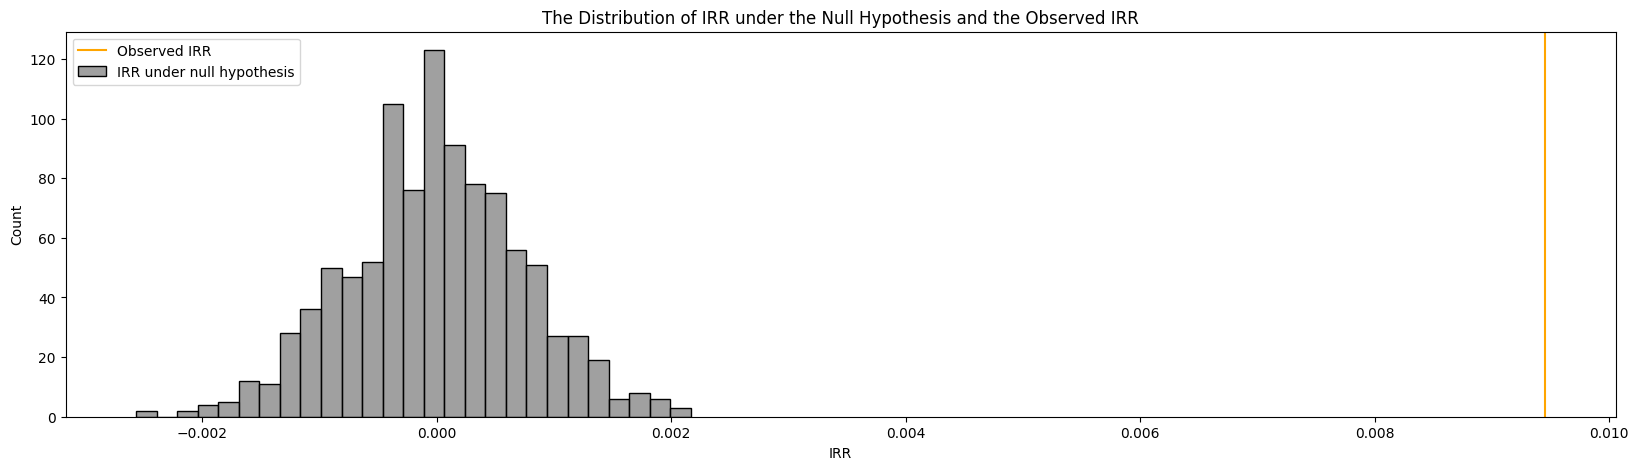

empirical pvalue: 0.0


In [ ]:
def drawPermutationGraph(permutation_value,observed_value,value_name,alternative='two-sided'):
  """
  Generate a histogram of the permutation values to form a null
  distribution.
  Draw a vertical line for the observed value for comparison.
  It will return the empirical p-value.

  Input parameters:
      permutation_value: [list] a list containing values generated
                from permutation
      observed_value: [float] the observed value
      value_name: [str] the name of observed value
      alternative: [str] the way to generate the empirical p-value,
             it could be:
              'two-sided': the empricial p-value is the ratio
                     of permutation values with absolute
                     value larger than that of observed
                     value
              'larger': the empricial p-value is the ratio
                    of permutation values larger than
                    or equal to the observed value
              'smaller': the empricial p-value is the ratio
                    of permutation values smaller than
                    or equal to the observed value

  Output value:
      empirical_pvalue: [float] the empirical p-value
  """

  # Compute the empirical p-value
  empirical_pvalue = None
  if alternative == 'larger':
    empirical_pvalue = len(list(filter(lambda x:x>=observed_value,permutation_value))) / len(permutation_value)
  elif alternative == 'smaller':
    empirical_pvalue = len(list(filter(lambda x:x<=observed_value,permutation_value))) / len(permutation_value)
  elif alternative == 'two-sided':
    empirical_pvalue = len(list(filter(lambda x:abs(x)>=abs(observed_value),permutation_value))) / len(permutation_value)

  # Create a histogram
  plt.figure(figsize=(20,5))
  sns.histplot(permutation_value,color='grey',label = '{} under null hypothesis'.format(value_name))
  plt.title("The Distribution of {} under the Null Hypothesis and the Observed {}".format(value_name,value_name))
  plt.axvline(x=observed_value, color='orange',label = "Observed {}".format(value_name))
  plt.xlabel(value_name)
  plt.legend();
  plt.show();
  print('empirical pvalue:',empirical_pvalue)
  return empirical_pvalue

empirical_pvalue = drawPermutationGraph(record,real_IRR,'IRR','larger')

### Bootstrapping Analysis

In [ ]:
def compute_NIR(df):
  """
  Compute the NIR value for the input dataset

  Input parameters:
      df: pandas dataframe
  Output value:
      NIR: [float]
  """
  purch_treat = df.query('Promotion=="Yes" and purchase==1').shape[0]
  purch_ctrl = df.query('Promotion=="No" and purchase==1').shape[0]
  cust_treat = df.query('Promotion=="Yes"').shape[0]
  NIR = 10 * purch_treat - 0.15 * cust_treat - 10 * purch_ctrl
  return NIR

def bootstrapping(df,metric = None):
  """
  Genearte the bootstrapping values of the given metric

  Input parameters:
      df: pandas dataframe
      metric: [str] the name of the metric, it could be:
           'IRR'
           'NIR'
  Output value:
      record: [list] a list containing the bootstrapping values
  """
  n_trials = 1000
  record = []
  for _ in range(n_trials):
    temp_df = df.sample(frac=1,replace=True)
    if metric == 'IRR':
      temp_IRR = compute_IRR(temp_df)
      record.append(temp_IRR)
    elif metric == 'NIR':
      temp_NIR = compute_NIR(temp_df)
      record.append(temp_NIR)
  return record


In [ ]:
bootstrap_IRR = bootstrapping(train_data,'IRR')
real_IRR = compute_IRR(train_data)


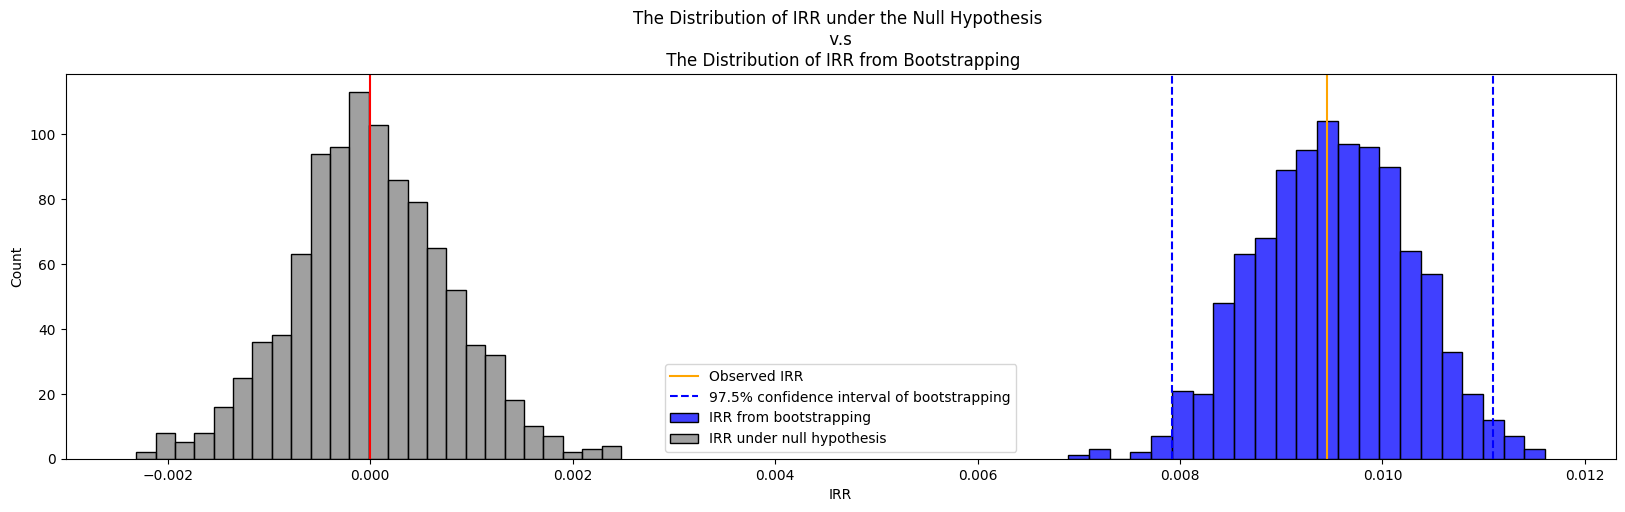

p-value: 0.0


In [ ]:
def drawBootstrappingGraph(bootstrap_value,observed_value,value_name,alternative='two-sided',null_mean=0,alpha=0.05):
  """
  Generate a histogram of the bootstrap metric values and a
  histogram of the metric value under null hypothesis side by side
  for comparison.



  Input parameters:
      bootstrap_value: [list] a list containing values generated
                from bootstrapping
      observed_value: [float] the observed value
      value_name: [str] the name of observed value
      alternative: [str] a string indicating the way to generate
                the p-value,it could be:
            'two-sided': the p-value is the probability
                    that sampling a value from the
                    null hypothesis and the value is
                    as extreme or more extreme than
                    that the observed value
            'larger': the p-value is the probability
                  that sampling a value from the
                  null hypothesis and the value is
                  larger than the observed value
            'smaller': the p-value is the probability
                    that sampling a value from the
                    null hypothesis and the value is
                    smaller than the observed value

  Output value:
      p_value: [float] the p-value
  """
  confidence = 1 - alpha
  lower_limit = np.percentile(bootstrap_value, (1 - confidence)/2 * 100)
  upper_limit = np.percentile(bootstrap_value, (1 + confidence)/2 * 100)
  std_bootstrap = np.std(bootstrap_value)
  p_value = None
  z = (observed_value - null_mean) / std_bootstrap
  if alternative == 'two-sided':
    if z > 0:
      p_value = 2 * (1 - stats.norm.cdf(z,0,1))
    else:
      p_value = 2 * (stats.norm.cdf(z,0,1))
  elif alternative == 'larger':
    p_value = 1 - stats.norm.cdf(z,0,1)
  elif alternative == 'smaller':
    p_value = stats.norm.cdf(z,0,1)


  # Create a histogram
  plt.figure(figsize=(20,5))
  null_distribution = np.random.normal(null_mean,std_bootstrap,len(bootstrap_value))
  sns.histplot(bootstrap_value,color='blue',label='{} from bootstrapping'.format(value_name))
  sns.histplot(null_distribution,color='grey',label = '{} under null hypothesis'.format(value_name))
  plt.title("The Distribution of {} under the Null Hypothesis \n v.s \n The Distribution of {} from Bootstrapping".format(value_name,value_name))
  plt.axvline(x=0, color='red')
  plt.axvline(x=observed_value, color='orange',label = "Observed {}".format(value_name))
  plt.axvline(x=lower_limit, color='blue',linestyle='--')
  plt.axvline(x=upper_limit, color='blue',linestyle='--',label='{}% confidence interval of bootstrapping'.format(confidence*100))
  plt.xlabel(value_name)
  plt.legend();
  plt.show();
  print('p-value:',p_value)
  return p_value

corrected_alpha = 0.025
p_value = drawBootstrappingGraph(bootstrap_IRR,real_IRR,'IRR',alternative='larger',null_mean=0,alpha=corrected_alpha)



## Conclusion of IRR

From the bootstrapping analysis graph, we see that the confidence interval of bootstrapping values does not include the difference of zero. Additionly,
all the p-values from the above analysises are under $\alpha_{corrected}$. Thus, we can reject our null hypothesis and conclude that IRR is statistically significant larger in treatment group.




## NIR
* **Net Incremental Revenue (NIR)**

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

Unlike IRR, which is the difference with two ratios from 2 independent poplations and thus allow a formal hypothesis test. For NIR, we can only use non-parametric method (bootstrapping) here.

### Bootstrapping Analysis

$$ H_{0}: NIR \le 0 $$
$$ H_{a}: NIR > 0 $$

$$ \alpha = 0.05 $$  

Since we got IRR and NIR these two measurements here. We need to correct the signifiance value. Here I will use Bonferroni correction:
 $$\alpha_{correctd} = \frac {\alpha}{number\;of\;measurements} = \frac {0.05}{2} = 0.025 $$

In [ ]:
real_NIR = compute_NIR(train_data)
bootstrapped_NIR = bootstrapping(train_data,'NIR')

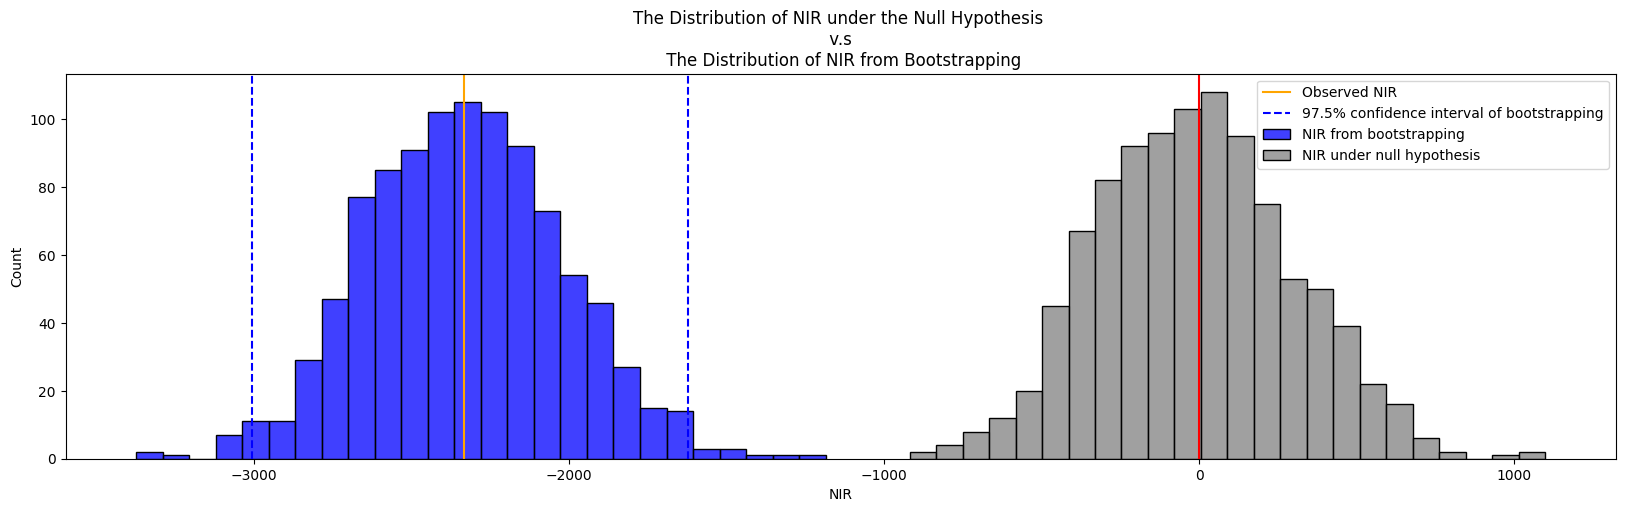

p-value: 0.9999999999999768


In [ ]:
p_value = drawBootstrappingGraph(bootstrapped_NIR,real_NIR,'NIR',alternative='larger',null_mean=0,alpha=corrected_alpha)

## Conclusion of NIR

From the bootstrapping analysis graph, we see that the confidence interval of bootstrapping values does not include the difference of zero. Additionly,
the p-value is larger than $\alpha_{corrected}$. Thus, we cannot reject our null hypothesis

## Conclusion of Q1

The promotional strategy significantly increased the IRR but failed to positively impact the Net Incremental Revenue.

Although the purchase rate is statistically significantly higher among individuals who received the promotion compared to those who did not, the increase in purchase rate does not offset the cost of the promotion, resulting in a negative Net Incremental Revenue (NIR).

Consequently, to enhance the NIR and refine our targeted promotion strategy, we plan to develop a machine learning model. This model will be designed to accurately identify potential customers who are more inclined to make a purchase upon receiving a promotion.


# Q2: Use Machine learning model to improve targeted promotion

In [ ]:
train_data
X = train_data.drop(['ID','Promotion','purchase'],axis=1)
y = train_data['purchase']

In [ ]:
def tuneRFmodel(X,y):
  clf = RandomForestClassifier(class_weight='balanced_subsample')
  param_dist = {
    'max_samples':[None,0.5,0.7,0.9],
    'max_depth' : [int(x) for x in np.linspace(start=1, stop=30, num = 10)],
    'n_estimators':[int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
  }
  # run randomized search
  n_iter_search = 40
  random_search = RandomizedSearchCV(
      clf, param_distributions=param_dist,cv=3,n_iter=n_iter_search,n_jobs=4,scoring='roc_auc'
  )
  return random_search.fit(X,y)

X = train_data.drop(['ID','Promotion','purchase'],axis=1)
y = train_data['purchase']
model = tuneRFmodel(X,y)




/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Check the classifier's performance of training data
from sklearn.metrics import classification_report
y_predicted = model.predict(X)
print(classification_report(y, y_predicted))

              precision    recall  f1-score   support

           0       0.99      0.55      0.71     83494
           1       0.02      0.69      0.04      1040

    accuracy                           0.55     84534
   macro avg       0.51      0.62      0.37     84534
weighted avg       0.98      0.55      0.70     84534



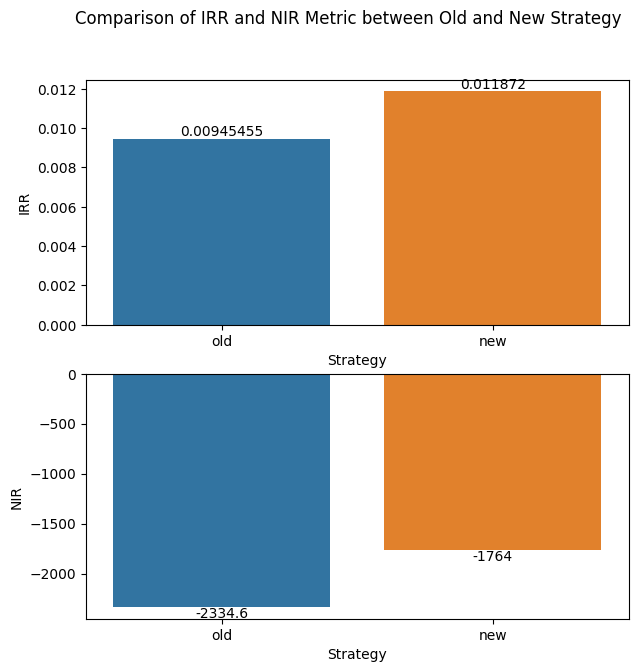

In [ ]:
# Check the changes in IRR and NIR between old and new strategies
y_predicted = ['Yes' if p==1 else 'No' for p in y_predicted]
temp_train = train_data.copy()
temp_train['Promotion'] = y_predicted
old_IRR = compute_IRR(train_data)
new_IRR = compute_IRR(temp_train)
old_NIR = compute_NIR(train_data)
new_NIR = compute_NIR(temp_train)
df_IRR = pd.DataFrame({'IRR':[old_IRR,new_IRR],'Strategy':['old','new']})
df_NIR = pd.DataFrame({'NIR':[old_NIR,new_NIR],'Strategy':['old','new']})

# Visualize the result
fig, axes = plt.subplots(2, 1, figsize=(7, 7))
fig.suptitle('Comparison of IRR and NIR Metric between Old and New Strategy')
ax = sns.barplot(ax=axes[0], data=df_IRR, x='Strategy', y='IRR')
ax.bar_label(ax.containers[0])
ax = sns.barplot(ax=axes[1], data=df_NIR, x='Strategy', y='NIR')
ax.bar_label(ax.containers[0])
fig.show();


In [ ]:
def promotion_strategy(df,model):
    '''
    INPUT
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an
                   individual should recieve a promotion
                   should be the length of df.shape[0]

    Ex:
    INPUT: df

    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2

    OUTPUT: promotion

    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and
    the last should not.
    '''
    predicted_y = model.predict(df)
    promotion = np.array(["Yes" if p==1 else "No" for p in predicted_y])
    return promotion

In [ ]:
# This will test your results, and provide you back some information
# on how well your promotion_strategy will work in practice
from test_result_colab import test_results, score
test_results(promotion_strategy,model)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0195.

Your nir with this strategy is 407.55.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01954320836925926, 407.54999999999995)


# Conclusions
With the machine learning model, we can improve the IRR and NIR metrics on training set as well as test set.



